## Pytorch Ignite

In [1]:
#installing pytorch ignite
!pip install pytorch-ignite

In [3]:
import torch
from torch import nn
from torchvision import datasets
from torchvision import datasets, transforms
import ignite
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers import TensorboardLogger, global_step_from_engine

## Defining the MLP model

In [4]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Changed the output layer to output 10 classes instead of 1000 classes
        self.flatten = nn.Flatten()
        self.linear =  nn.Sequential(
            nn.Linear(28*28,128),
            nn.ReLU(),
            nn.Linear(128,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(512,10)
        )

    def forward(self, x):
        logits = self.flatten(x)
        return self.linear(logits)

## Loading MNIST Fashion Dataset

In [5]:
# Data loading and transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 10478754.17it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 208776.89it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3902812.47it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21294158.77it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



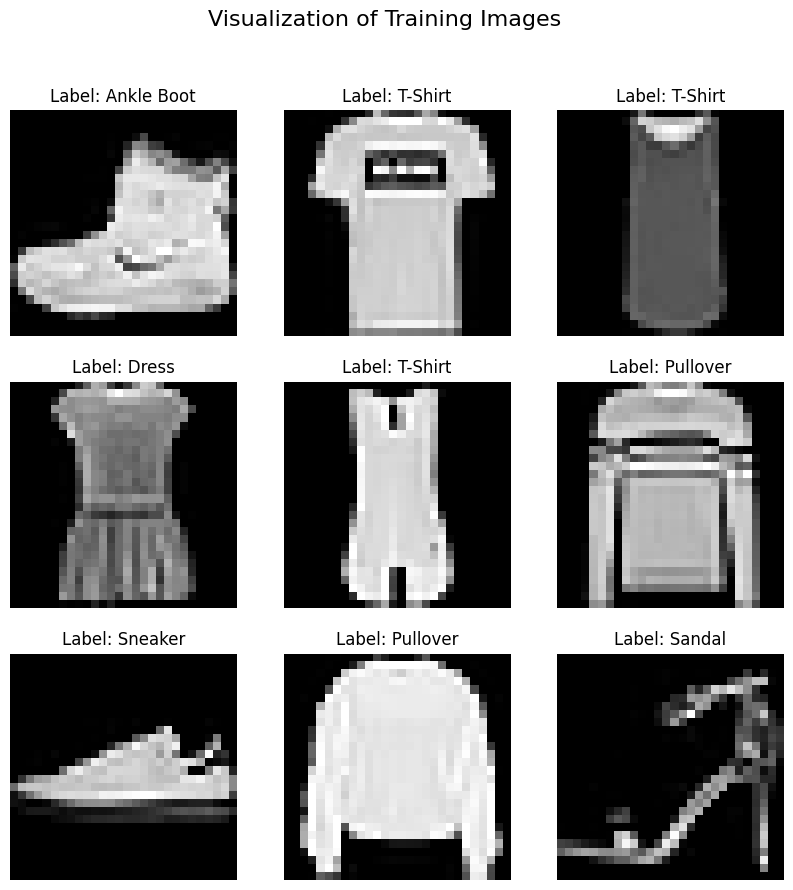

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

import matplotlib.pyplot as plt

# Get a batch of training data
images, labels = next(iter(DataLoader(train_dataset, batch_size=9)))

# Plot the images in the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(f"Label: {labels_map[labels[i].item()]}", fontsize=12)
    plt.axis('off')

plt.suptitle("Visualization of Training Images", fontsize=16)
plt.show()


In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Initlaizing model and required paramters for the training

In [38]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [39]:
# define step training function

def train_step(engine,batch):
  model.train()
  x,y =batch[0].to(device), batch[1].to(device)
  optimizer.zero_grad()
  y_pred = model(x)
  loss= criterion(y_pred,y)
  loss.backward()
  optimizer.step()
  return loss.item()

#define validation step
def validation_step(engine, batch):
    model.eval()
    with torch.no_grad():
        x, y = batch[0].to(device), batch[1].to(device)
        y_pred = model(x)
        return y_pred, y

In [40]:
trainer = create_supervised_trainer(model, optimizer, criterion, device)

val_metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

val_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)


In [41]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}] Loss: {engine.state.output:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    print(f"Training Results - Epoch: {engine.state.epoch}  Avg loss: {metrics['loss']:.2f} Avg accuracy: {metrics['accuracy']:.2f}")

In [42]:
# Score function to return current value of any metric we defined above in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]

# Checkpoint to store n_saved best models wrt score function
model_checkpoint = ModelCheckpoint(
    "checkpoint",
    n_saved=2,
    filename_prefix="best",
    score_function=score_function,
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer), # helps fetch the trainer's state
)

# Save the model after every epoch of val_evaluator is completed
val_evaluator.add_event_handler(Events.COMPLETED, model_checkpoint, {"model": model})

In [43]:
trainer.state.epoch = 0

In [44]:
trainer.run(train_loader,max_epochs= 6)

Epoch[1] Loss: 0.24
Training Results - Epoch: 1  Avg loss: 0.39 Avg accuracy: 0.86
Epoch[2] Loss: 0.30
Training Results - Epoch: 2  Avg loss: 0.34 Avg accuracy: 0.87
Epoch[3] Loss: 0.35
Training Results - Epoch: 3  Avg loss: 0.31 Avg accuracy: 0.88
Epoch[4] Loss: 0.30
Training Results - Epoch: 4  Avg loss: 0.29 Avg accuracy: 0.89
Epoch[5] Loss: 0.23
Training Results - Epoch: 5  Avg loss: 0.27 Avg accuracy: 0.90
Epoch[6] Loss: 0.31
Training Results - Epoch: 6  Avg loss: 0.27 Avg accuracy: 0.89


State:
	iteration: 5628
	epoch: 6
	epoch_length: 938
	max_epochs: 6
	output: 0.3143666386604309
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

# Save model state_dict

In [45]:
torch.save(model.state_dict(), 'MNSIT_ignite_model.pth' )

## Loading model and inference from loaded model

In [54]:
model1 = Net()

model1.load_state_dict(torch.load('MNSIT_ignite_model.pth'))

<All keys matched successfully>

In [56]:
sample, label = test_dataset[35]  # Get a single sample
sample_reshaped = sample.unsqueeze(0)
# Perform inference
with torch.no_grad():
    output = model1(sample)
    predicted_index = output.argmax(dim=1).item()

# Map the predicted class to the actual label
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f'Predicted: {predicted_index}')
print(f'Target: {label}')

Predicted: 0
Target: 0


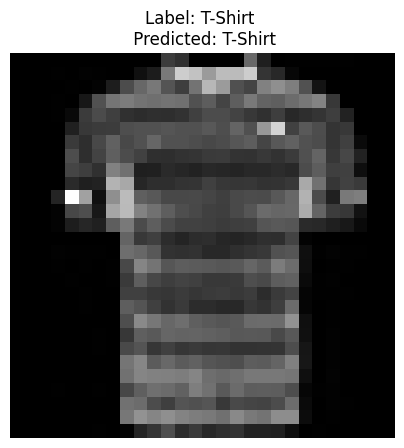

In [57]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(5, 5))
plt.title(f"Label: {labels_map[label]} \n Predicted: {labels_map[predicted_index]}")
plt.imshow(sample.squeeze(), cmap="gray")
plt.xlabel(labels_map[predicted_index])
plt.axis("off")
plt.show()